# Experiment description
## Hypothesis: 
We can train sepp model at city aggregation using one-month data

## Method: 

Train model using three month data (2017-01-01 to 2017-01-07) at city scope. Try different parameters to guarantee model convergence:
- Default parameters.
- Change self._initial_time_bandwidth = 24 * 60 / 10 # minutes
- Change self._initial_space_bandwidth = 50.0

In [16]:
%matplotlib inline
import pandas as pd
import pickle
import dateutil.parser
import pyproj
import open_cp
import open_cp.sepp as sepp
from PIL import Image
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [1]:
import import_ipynb
import training_sepp_builtin

importing Jupyter notebook from training_sepp_builtin.ipynb
^C
  Using cached https://github.com/MatthewDaws/SEPP/zipball/master
You are using pip version 18.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Failed to import `rtree`.
Failed to import `rtree`.


In [12]:
def selectDataPrediction(nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
        
    dfloc = df[df["LOCALIDAD"]==nameLoc]
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_crime = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    
    #Generando Grilla para los algoritmos. 
    maxx = max(xcoords)
    minx = min(xcoords)
    maxy = max(ycoords)
    miny = min(ycoords)

    region = open_cp.RectangularRegion(xmin=minx, xmax=maxx, ymin=miny, ymax=maxy)
    
    return (points_crime,region)


In [13]:
def selectDataTraining(df,nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
        
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_train = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    return (points_train,timestamps,xcoords, ycoords)

In [14]:
def trainModel_parameters(df,nameLoc,dateIni,dateEnd,time_bw,space_bw):
    points_train,timestamps,xcoords, ycoords = selectDataTraining(df,nameLoc,dateIni,dateEnd)
    plt.scatter(xcoords, ycoords)
    print([timestamps])
    trainer = sepp.SEPPTrainer()
    trainer._initial_time_bandwidth = time_bw
    trainer._initial_space_bandwidth = space_bw
    print('time BW set on: ',trainer._initial_time_bandwidth)
    print('space BW set on: ',trainer._initial_space_bandwidth)
    trainer.data = points_train    
    while True:
        try:
            predictor = trainer.train()
            break
        except (RuntimeError, ValueError) as e:
            print(e)
            pass
    return predictor 

In [4]:
def load_model(localidad, train_date):
    custom_path = path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+train_date+'.pkl'
    infile = open(custom_path,'rb')
    modelCrime = pickle.load(infile)
    infile.close()
    return modelCrime

In [5]:
def run_prediction(localidad,modelCrime,predict_time):
    points_crime,region = selectData(localidad,initial_date_prediction,final_date_prediction)
    modelCrime.data = points_crime 
    prediction = modelCrime.predict(predict_time)
    gridpred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 150, 150)
    hitrates = open_cp.evaluation.hit_rates(gridpred, points_crime, [0.01,0.1])
    return gridpred, hitrates

In [6]:
def plot_gridpred(localidad,predict_time,gridpred):
    fig, ax = plt.subplots(figsize=(20,10))
    m = ax.pcolormesh(*gridpred.mesh_data(), gridpred.intensity_matrix, cmap="CMRmap_r")
    ax.set_title("Predicción localidad: "+localidad+'; fecha: '+str(predict_time))
    fig.colorbar(m, ax=ax)

## Select data

In [7]:
path = '/Users/anamaria/Desktop/dev/security_project'

In [8]:
df = pd.read_csv(path+'/datasets/verify_enrich_nuse_29112019.csv')

In [9]:
initial_date = '2017-01-01'
final_date = '2017-01-07'

## Training experiments

### Scenario 1: default parameters 

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
0 standard deviation: [2082.70620625    0.            0.        ]
0 standard deviation: [2081.89115108    0.            0.        ]
0 standard deviation: [2091.23662465    0.            0.        ]
Too small variance!
Too small variance!
0 standard deviation: [2088.53490434    0.            0.        ]
0 standard deviation: [2072.23554083    0.            0.        ]
0 standard deviation: [2074.2189138    0.           0.       ]
0 standard deviation: [2089.87258615    0.            0.        ]
0 standard deviation: [2085.21486577    0.            0.        ]
0 standard

KeyboardInterrupt: 

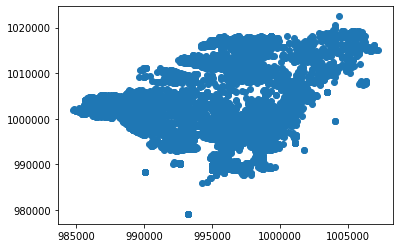

In [10]:
localidad = 'city'
city_predictor = training_sepp_builtin.trainModel_1(df,localidad,initial_date, final_date)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

### Result scenario 1: 
- Number of realizations: 25
- Average time elapsed for realization: 8 minutes 
- 0 standard deviation and small variance errors

### Scenario 2: sweep initial time BW
- Default: self._initial_time_bandwidth = 24 * 60 / 10 # minutes
- Set 1 parameters: magnitude order variation over default parameter value [14, 144, 1440]
- Set 2 parameters: upper linear variation over default value [288, 576, 864, 1152]

#### Parameter = 14

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  14
space BW set on:  50
0 standard deviation: [2079.01870484    0.            0.        ]
Too small variance!
0 standard deviation: [2089.68178509    0.            0.        ]
0 standard deviation: [2063.55453842    0.            0.        ]
Too small variance!
0 standard deviation: [2080.38773473    0.            0.        ]
Too small variance!
Too small variance!
0 standard deviation: [2080.09600079    0.            0.        ]


KeyboardInterrupt: 

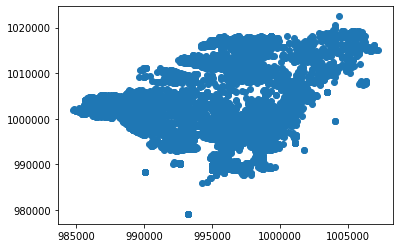

In [17]:
localidad = 'city'
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,time_bw=14,space_bw=50)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 4 minutes
- 0 standard deviation and small variance errors

#### Parameter = 144

Experiment with this parameter was implemented on scenario 1 (parameters default values)
Results: 
- Number of realizations: 25
- Average time elapsed for realization: 8 minutes 
- 0 standard deviation and small variance errors

#### Parameter = 1440

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  1440
space BW set on:  50
0 standard deviation: [2079.74483713    0.            0.        ]
0 standard deviation: [2079.76764064    0.            0.        ]
0 standard deviation: [2086.97642204    0.            0.        ]
0 standard deviation: [2086.12797458    0.            0.        ]
0 standard deviation: [2084.89303775    0.            0.        ]
0 standard deviation: [2090.86089748    0.            0.        ]
0 standard deviation: [2079.25392247    0.            0.        ]
0 standard deviation: [2084.57131527    0.            0.        ]
0 st

KeyboardInterrupt: 

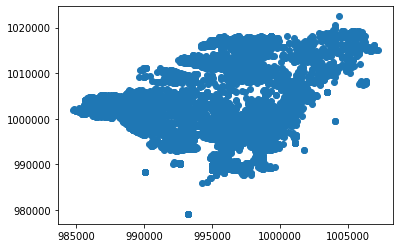

In [18]:
localidad = 'city'
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,time_bw=1440,space_bw=50)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 20
- Average time elapsed for realization: 3 min
- 0 standard deviation and small variance errors

#### Parameter = 14400

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  14400
space BW set on:  50
0 standard deviation: [2089.56581783    0.            0.        ]
0 standard deviation: [2078.78717369    0.            0.        ]
0 standard deviation: [2073.7531168    0.           0.       ]
Too small variance!
Too small variance!
0 standard deviation: [2079.60640315    0.            0.        ]
0 standard deviation: [2078.56825548    0.            0.        ]
0 standard deviation: [2080.43478729    0.            0.        ]
0 standard deviation: [2081.39915325    0.            0.        ]
0 standard deviation: [2076.6462

KeyboardInterrupt: 

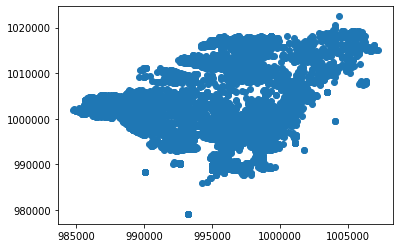

In [19]:
localidad = 'city'
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,time_bw=14400,space_bw=50)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 15
- Average time elapsed for realization: 3.6 min
- 0 standard deviation and small variance errors

### =================================================

#### Parameter = 288

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  288
space BW set on:  50
0 standard deviation: [2091.28179802    0.            0.        ]
0 standard deviation: [2077.57380131    0.            0.        ]
0 standard deviation: [2074.02330922    0.            0.        ]
0 standard deviation: [2081.2783744    0.           0.       ]
0 standard deviation: [2080.26408272    0.            0.        ]
0 standard deviation: [2084.64158527    0.            0.        ]
Too small variance!
0 standard deviation: [2079.33179788    0.            0.        ]
Too small variance!
0 standard deviation: [2089.080177

KeyboardInterrupt: 

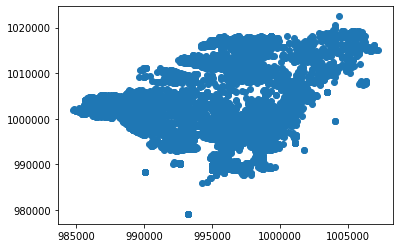

In [23]:
localidad = 'city'
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,time_bw=288,space_bw=50)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 10
- Average time elapsed for realization: 4 min
- 0 standard deviation and small variance errors

### Scenario 3: sweep initial space BW
- Default: self._initial_space_bandwidth = 50
- Set 1 parameters: magnitude order variation over default parameter value [5, 50, 500]

#### Parameter = 5

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  5
0 standard deviation: [364.46055305   0.           0.        ]
0 standard deviation: [117.77321171   0.           0.        ]
0 standard deviation: [100.71402317   0.           0.        ]
0 standard deviation: [123.20107879   0.           0.        ]
0 standard deviation: [124.06909998   0.           0.        ]
0 standard deviation: [113.97046401   0.           0.        ]
0 standard deviation: [121.15206018   0.           0.        ]
0 standard deviation: [102.3281559   0.          0.       ]
Too small variance!
0 standard de

KeyboardInterrupt: 

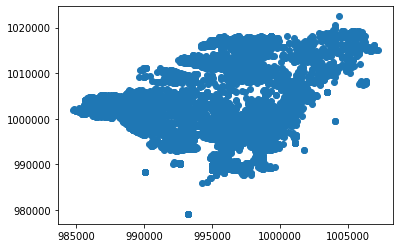

In [20]:
localidad = 'city'
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,time_bw=144,space_bw=5)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 20
- Average time elapsed for realization: 20 seg.
- 0 standard deviation and small variance errors

#### Parameter = 50

Experiment with this parameter was implemented on scenario 1 (parameters default values)
Results
- Number of realizations: 25
- Average time elapsed for realization: 8 minutes 
- 0 standard deviation and small variance errors

#### Parameter = 500

TimeStamps
<class 'pandas.core.series.Series'>
[164      2017-01-01 19:28:00
165      2017-01-01 08:52:00
166      2017-01-01 03:49:00
167      2017-01-01 11:06:00
168      2017-01-01 06:54:00
                 ...        
699441   2017-01-06 23:04:00
699442   2017-01-06 21:17:00
699443   2017-01-06 19:19:00
699447   2017-01-06 18:26:00
699448   2017-01-06 13:30:00
Name: FECHA_HORA_TS, Length: 6611, dtype: datetime64[ns]]
time BW set on:  144
space BW set on:  500
0 standard deviation: [2096.50382973    0.            0.        ]
Too small variance!
0 standard deviation: [2085.44361123    0.            0.        ]
0 standard deviation: [2072.4373338    0.           0.       ]
0 standard deviation: [2076.00705295    0.            0.        ]
0 standard deviation: [2092.6344176    0.           0.       ]
Too small variance!


KeyboardInterrupt: 

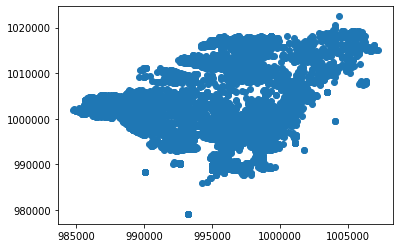

In [21]:
localidad = 'city'
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,time_bw=144,space_bw=500)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 7
- Average time elapsed for realization: 11 min
- 0 standard deviation and small variance errors